# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                                                                                                                                                                                                                    
Sample_158  P80748                                                                                                                                                                                                                                                               19.864
Sample_108  Q9Y617                                                                                                                                                                                                                                                               14.613
Sample_039  A0A140T8Z9;A0A140T900;A0A140T909;A0A140T914;A0A140T961;A0A140T968;A0A140T977;A0A140T980;A0A140T992;A0A140T9A6;A0A140T9D6;A0A140T9F8;A0A140T9G7;A0A140T9G9;A0A

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups               
Sample_171  Q9Y6Y9                           9.735
Sample_059  B5MBX2;F8WE86;P20062;P20062-2   18.611
Sample_041  Q9H6B4                          14.451
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.401
            A0A075B6Q5                 14.312
            A0A075B6R2                 13.179
            A0A075B6S5                 12.646
            A0A087WSY4                 13.637
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.327
            Q9UI40;Q9UI40-2            13.413
            Q9UIW2                     12.377
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.261
            Q9UP79                     12.525
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.092,15.050,16.842,19.863,15.934,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.657,19.067,...,15.528,15.576,14.071,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.790,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.652,17.705,17.039,15.953,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.610,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.480,15.345,17.084,18.708,14.249,19.433,11.091,11.010
Sample_207,15.739,16.877,15.469,16.898,15.070,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.560,11.203,13.117,12.862,12.685,12.392,14.058,12.901,12.517,13.117
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.708,19.067,16.127,...,12.523,13.048,11.004,14.430,12.494,12.391,12.960,13.392,11.924,13.236
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.618,12.294,11.307,12.637,13.004,11.691,13.901,13.575,12.040,12.467
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.375,12.642,12.333,12.185,12.083,13.269,12.924,12.375,13.599,12.620
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.173,12.609,12.284,12.270,12.925,13.197,11.499,13.057,12.770,12.488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.728,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 323.81it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.98it/s]

100%|██████████| 2/2 [00:00<00:00,  8.94it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.46it/s]

100%|██████████| 3/3 [00:00<00:00,  5.38it/s]

100%|██████████| 3/3 [00:00<00:00,  5.67it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.90it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.38it/s]

100%|██████████| 4/4 [00:00<00:00,  5.55it/s]

100%|██████████| 4/4 [00:00<00:00,  6.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  9.02it/s]

 60%|██████    | 3/5 [00:00<00:00,  6.07it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.55it/s]

100%|██████████| 5/5 [00:01<00:00,  4.25it/s]

100%|██████████| 5/5 [00:01<00:00,  4.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.98it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.07it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.25it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.89it/s]

100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

100%|██████████| 6/6 [00:01<00:00,  4.18it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.57it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.41it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.42it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.93it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.85it/s]

100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

100%|██████████| 7/7 [00:01<00:00,  4.90it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.06it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.49it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.16it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.99it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.94it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.04it/s]

100%|██████████| 8/8 [00:01<00:00,  4.15it/s]

100%|██████████| 8/8 [00:01<00:00,  4.22it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.65it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.09it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.69it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.08it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.23it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.36it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.40it/s]

100%|██████████| 9/9 [00:01<00:00,  4.38it/s]

100%|██████████| 9/9 [00:01<00:00,  4.51it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.76it/s]

 30%|███       | 3/10 [00:00<00:01,  5.12it/s]

 40%|████      | 4/10 [00:00<00:01,  3.95it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.97it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.81it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.10it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.35it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.34it/s]

100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.09it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.97it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.23it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.03it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.08it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.22it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.47it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.47it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.48it/s]

100%|██████████| 11/11 [00:02<00:00,  4.55it/s]

100%|██████████| 11/11 [00:02<00:00,  4.50it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.06it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.12it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.81it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.48it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.38it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.17it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.21it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.10it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.08it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.78it/s]

100%|██████████| 12/12 [00:02<00:00,  4.12it/s]

100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.22it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.83it/s]

 31%|███       | 4/13 [00:00<00:02,  4.37it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.20it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.94it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.74it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.47it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.50it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.53it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.55it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.74it/s]

100%|██████████| 13/13 [00:03<00:00,  3.99it/s]

100%|██████████| 13/13 [00:03<00:00,  3.94it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.45it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.03it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.65it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.26it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.20it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.75it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.70it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.54it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.60it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.55it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.82it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.03it/s]

100%|██████████| 14/14 [00:03<00:00,  4.08it/s]

100%|██████████| 14/14 [00:03<00:00,  4.03it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.15it/s]

 20%|██        | 3/15 [00:00<00:01,  6.30it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.39it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.79it/s]

 40%|████      | 6/15 [00:01<00:01,  4.63it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.59it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.41it/s]

 60%|██████    | 9/15 [00:01<00:01,  3.94it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.80it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.71it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.99it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.08it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.04it/s]

100%|██████████| 15/15 [00:04<00:00,  2.92it/s]

100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.061 0.024          0.859 0.237       0.162   
2             0.006 0.006      0.056 0.018          0.774 0.071       0.727   
3             0.007 0.007      0.054 0.022          0.770 0.070       0.713   
4             0.006 0.006      0.063 0.026          0.784 0.067       0.730   
5             0.006 0.005      0.049 0.019          0.810 0.083       0.780   
6             0.005 0.005      0.058 0.026          0.808 0.082       0.786   
7             0.007 0.007      0.069 0.024          0.803 0.081       0.788   
8             0.005 0.005      0.048 0.018          0.793 0.085       0.795   
9             0.005 0.004      0.050 0.025          0.816 0.079       0.813   
10            0.005 0.004      0.047 0.020          0.814 0.077       0.825   
11            0.004 0.003      0.044 0.018          0.869 0.070       0.837   
12            0.004 0.003      0.045 0.017          0.864 0.078       0.829   
13            0.005 0.004      0.051 0.023          0.854 0.084       0.822   
14            0.004 0.003      0.041 0.012          0.850 0.078       0.820   
15            0.005 0.003      0.041 0.012          0.848 0.078       0.816   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.090   0.264 0.127                  0.573 0.043        0.869   
2          0.121   0.744 0.083                  0.786 0.063        0.879   
3          0.110   0.736 0.078                  0.779 0.060        0.875   
4          0.105   0.751 0.070                  0.791 0.054        0.875   
5          0.108   0.789 0.073                  0.821 0.059        0.887   
6          0.111   0.792 0.075                  0.823 0.060        0.914   
7          0.112   0.791 0.079                  0.822 0.064        0.910   
8          0.119   0.788 0.081                  0.820 0.067        0.909   
9          0.108   0.810 0.073                  0.839 0.062        0.914   
10         0.101   0.815 0.068                  0.842 0.059        0.917   
11         0.090   0.849 0.059                  0.871 0.051        0.930   
12         0.090   0.843 0.065                  0.865 0.056        0.928   
13         0.093   0.834 0.071                  0.858 0.061        0.928   
14         0.093   0.831 0.068                  0.856 0.059        0.926   
15         0.093   0.829 0.069                  0.854 0.059        0.925   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.832 0.087        210.000 0.000  
2          0.047                  0.853 0.059        210.000 0.000  
3          0.047                  0.849 0.058        210.000 0.000  
4          0.046                  0.846 0.057        210.000 0.000  
5          0.048                  0.857 0.068        210.000 0.000  
6          0.042                  0.889 0.057        210.000 0.000  
7          0.042                  0.885 0.059        210.000 0.000  
8          0.045                  0.885 0.058        210.000 0.000  
9          0.044                  0.892 0.054        210.000 0.000  
10         0.043                  0.897 0.053        210.000 0.000  
11         0.041                  0.916 0.048        210.000 0.000  
12         0.042                  0.913 0.049        210.000 0.000  
13         0.043                  0.914 0.050        210.000 0.000  
14         0.043                  0.913 0.048        210.000 0.000  
15         0.042                  0.911 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 481.99it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.84it/s]

100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.59it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.71it/s]

100%|██████████| 4/4 [00:00<00:00,  4.32it/s]

100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.63it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.58it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.79it/s]

100%|██████████| 5/5 [00:01<00:00,  4.26it/s]

100%|██████████| 5/5 [00:01<00:00,  4.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  9.33it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.92it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.91it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.49it/s]

100%|██████████| 6/6 [00:01<00:00,  3.88it/s]

100%|██████████| 6/6 [00:01<00:00,  4.55it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.11it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.80it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.52it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.43it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.13it/s]

100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.12it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.83it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.85it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.48it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.48it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.10it/s]

100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

100%|██████████| 8/8 [00:02<00:00,  3.66it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.99it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.88it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.50it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.34it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.00it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.73it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.70it/s]

100%|██████████| 9/9 [00:02<00:00,  2.53it/s]

100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.37it/s]

 30%|███       | 3/10 [00:00<00:01,  4.87it/s]

 40%|████      | 4/10 [00:00<00:01,  4.49it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.26it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.93it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.87it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.94it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.93it/s]

100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.79it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.04it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.85it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.69it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.22it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.00it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.73it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.79it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.83it/s]

100%|██████████| 11/11 [00:03<00:00,  2.90it/s]

100%|██████████| 11/11 [00:03<00:00,  3.15it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.06it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.70it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.26it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.20it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.27it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.41it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.56it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.65it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.50it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.61it/s]

100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

100%|██████████| 12/12 [00:03<00:00,  3.56it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.59it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.06it/s]

 31%|███       | 4/13 [00:01<00:02,  3.75it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.56it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.64it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.67it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.73it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.79it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.31it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.97it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.87it/s]

100%|██████████| 13/13 [00:03<00:00,  2.92it/s]

100%|██████████| 13/13 [00:03<00:00,  3.37it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.09it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.67it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.49it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.65it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.48it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.44it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.64it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.76it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.81it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.04it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.13it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.24it/s]

100%|██████████| 14/14 [00:04<00:00,  3.30it/s]

100%|██████████| 14/14 [00:04<00:00,  3.06it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.13it/s]

 20%|██        | 3/15 [00:00<00:02,  4.46it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.86it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.78it/s]

 40%|████      | 6/15 [00:01<00:02,  3.75it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.37it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.31it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.37it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.52it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.41it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.30it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.44it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.55it/s]

100%|██████████| 15/15 [00:04<00:00,  3.66it/s]

100%|██████████| 15/15 [00:04<00:00,  3.63it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.037 0.009          0.087 0.248       0.009   
2             0.004 0.002      0.048 0.024          0.669 0.126       0.499   
3             0.005 0.005      0.059 0.025          0.770 0.091       0.710   
4             0.005 0.005      0.047 0.017          0.748 0.084       0.708   
5             0.004 0.003      0.044 0.018          0.750 0.093       0.716   
6             0.004 0.002      0.052 0.021          0.765 0.095       0.757   
7             0.005 0.004      0.048 0.017          0.766 0.096       0.754   
8             0.007 0.006      0.070 0.024          0.768 0.096       0.750   
9             0.005 0.004      0.049 0.017          0.771 0.095       0.756   
10            0.006 0.005      0.062 0.025          0.783 0.096       0.788   
11            0.005 0.004      0.052 0.019          0.781 0.097       0.788   
12            0.006 0.005      0.067 0.026          0.802 0.086       0.799   
13            0.007 0.006      0.055 0.021          0.794 0.094       0.790   
14            0.004 0.002      0.039 0.012          0.812 0.091       0.805   
15            0.005 0.004      0.049 0.026          0.811 0.091       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.852   
2          0.111   0.564 0.096                  0.656 0.069        0.702   
3          0.114   0.732 0.083                  0.775 0.064        0.879   
4          0.124   0.720 0.087                  0.765 0.063        0.878   
5          0.127   0.725 0.089                  0.768 0.069        0.878   
6          0.107   0.756 0.079                  0.792 0.065        0.905   
7          0.104   0.754 0.078                  0.790 0.065        0.903   
8          0.105   0.754 0.079                  0.790 0.065        0.902   
9          0.098   0.759 0.075                  0.793 0.064        0.902   
10         0.118   0.780 0.087                  0.812 0.072        0.906   
11         0.121   0.778 0.086                  0.811 0.072        0.905   
12         0.095   0.796 0.069                  0.825 0.057        0.916   
13         0.100   0.787 0.074                  0.817 0.062        0.915   
14         0.094   0.804 0.069                  0.832 0.059        0.920   
15         0.096   0.803 0.069                  0.831 0.058        0.920   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.822 0.087        210.000 0.000  
2          0.087                  0.675 0.098        210.000 0.000  
3          0.047                  0.839 0.067        210.000 0.000  
4          0.047                  0.841 0.062        210.000 0.000  
5          0.050                  0.843 0.063        210.000 0.000  
6          0.048                  0.888 0.051        210.000 0.000  
7          0.048                  0.886 0.052        210.000 0.000  
8          0.048                  0.885 0.052        210.000 0.000  
9          0.050                  0.885 0.053        210.000 0.000  
10         0.050                  0.887 0.055        210.000 0.000  
11         0.049                  0.885 0.054        210.000 0.000  
12         0.045                  0.897 0.051        210.000 0.000  
13         0.046                  0.899 0.051        210.000 0.000  
14         0.044                  0.906 0.046        210.000 0.000  
15         0.043                  0.905 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 933.31it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 34.09it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 21.74it/s]

100%|██████████| 3/3 [00:00<00:00, 21.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 23.35it/s]

100%|██████████| 4/4 [00:00<00:00, 20.26it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 24.37it/s]

100%|██████████| 5/5 [00:00<00:00, 17.44it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.36it/s]

100%|██████████| 6/6 [00:00<00:00, 18.52it/s]

100%|██████████| 6/6 [00:00<00:00, 18.73it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.03it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 13.54it/s]

100%|██████████| 7/7 [00:00<00:00, 13.86it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 25.61it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 19.44it/s]

100%|██████████| 8/8 [00:00<00:00, 18.54it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.28it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.77it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 15.47it/s]

100%|██████████| 9/9 [00:00<00:00, 15.59it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.43it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.12it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.41it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.99it/s]

100%|██████████| 10/10 [00:00<00:00, 14.03it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.03it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 13.20it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.69it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.08it/s]

100%|██████████| 11/11 [00:00<00:00, 13.43it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 28.02it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 21.43it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 20.72it/s]

100%|██████████| 12/12 [00:00<00:00, 21.48it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.69it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.31it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.91it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.32it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 15.00it/s]

100%|██████████| 13/13 [00:00<00:00, 15.16it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.11it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.62it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.84it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 14.40it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.81it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 12.93it/s]

100%|██████████| 14/14 [00:01<00:00, 13.83it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 25.78it/s]

 40%|████      | 6/15 [00:00<00:00, 15.59it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 14.01it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 13.14it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.39it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 13.19it/s]

100%|██████████| 15/15 [00:01<00:00, 13.85it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.041 0.019          0.000 0.000       0.000   
2             0.005 0.005      0.051 0.021          0.671 0.115       0.452   
3             0.004 0.003      0.040 0.012          0.702 0.123       0.504   
4             0.005 0.004      0.045 0.017          0.662 0.132       0.475   
5             0.005 0.005      0.041 0.013          0.680 0.095       0.592   
6             0.003 0.000      0.043 0.015          0.644 0.106       0.565   
7             0.004 0.003      0.043 0.016          0.672 0.108       0.579   
8             0.004 0.005      0.044 0.025          0.671 0.095       0.605   
9             0.004 0.002      0.038 0.008          0.672 0.094       0.601   
10            0.004 0.002      0.036 0.010          0.681 0.091       0.613   
11            0.004 0.007      0.035 0.019          0.684 0.100       0.612   
12            0.005 0.005      0.046 0.016          0.678 0.107       0.609   
13            0.007 0.007      0.060 0.028          0.675 0.103       0.606   
14            0.007 0.007      0.057 0.026          0.671 0.098       0.605   
15            0.005 0.004      0.054 0.020          0.669 0.099       0.631   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.745   
2          0.111   0.534 0.102                  0.644 0.065        0.725   
3          0.111   0.578 0.089                  0.669 0.059        0.726   
4          0.121   0.544 0.102                  0.645 0.068        0.730   
5          0.115   0.625 0.082                  0.691 0.063        0.780   
6          0.121   0.594 0.095                  0.665 0.070        0.791   
7          0.115   0.614 0.088                  0.682 0.068        0.794   
8          0.112   0.629 0.080                  0.691 0.061        0.796   
9          0.113   0.628 0.083                  0.691 0.063        0.797   
10         0.114   0.638 0.080                  0.699 0.060        0.800   
11         0.111   0.639 0.080                  0.699 0.062        0.799   
12         0.111   0.634 0.083                  0.694 0.067        0.795   
13         0.105   0.631 0.077                  0.692 0.062        0.790   
14         0.106   0.629 0.076                  0.690 0.061        0.788   
15         0.110   0.644 0.087                  0.699 0.070        0.792   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.695 0.085        210.000 0.000  
2          0.075                  0.671 0.092        210.000 0.000  
3          0.074                  0.687 0.089        210.000 0.000  
4          0.076                  0.680 0.093        210.000 0.000  
5          0.067                  0.733 0.083        210.000 0.000  
6          0.067                  0.737 0.090        210.000 0.000  
7          0.064                  0.753 0.082        210.000 0.000  
8          0.065                  0.752 0.083        210.000 0.000  
9          0.065                  0.752 0.085        210.000 0.000  
10         0.065                  0.756 0.084        210.000 0.000  
11         0.064                  0.752 0.082        210.000 0.000  
12         0.067                  0.746 0.084        210.000 0.000  
13         0.066                  0.742 0.084        210.000 0.000  
14         0.066                  0.739 0.084        210.000 0.000  
15         0.063                  0.748 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,3,13,13
score_time,7,8,13
test_precision,11,14,3
test_recall,11,14,15
test_f1,11,14,15
test_balanced_accuracy,11,14,10
test_roc_auc,11,14,10
test_average_precision,11,14,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.18it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.38it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.55it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.30it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.27it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.19it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.06it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.33it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.96it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.86it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.70it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.04it/s]

100%|██████████| 14/14 [00:03<00:00,  3.24it/s]

100%|██████████| 14/14 [00:03<00:00,  3.55it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 20.65it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.51it/s]

 80%|████████  | 8/10 [00:00<00:00, 18.52it/s]

100%|██████████| 10/10 [00:00<00:00, 16.55it/s]

100%|██████████| 10/10 [00:00<00:00, 17.38it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.19it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.25it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.76it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.12it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.77it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.22it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  3.90it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.73it/s]

100%|██████████| 11/11 [00:02<00:00,  3.49it/s]

100%|██████████| 11/11 [00:02<00:00,  4.48it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


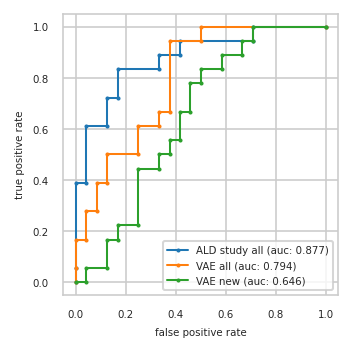

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.389   0.000 0.167   0.042 0.056
3          0.042 0.389   0.042 0.167   0.125 0.056
4          0.042 0.611   0.042 0.278   0.125 0.167
5          0.125 0.611   0.083 0.278   0.167 0.167
6          0.125 0.722   0.083 0.389   0.167 0.222
7          0.167 0.722   0.125 0.389   0.250 0.222
8          0.167 0.833   0.125 0.500   0.250 0.444
9          0.333 0.833   0.250 0.500   0.333 0.444
10         0.333 0.889   0.250 0.611   0.333 0.500
11         0.417 0.889   0.333 0.611   0.375 0.500
12         0.417 0.944   0.333 0.667   0.375 0.556
13         0.708 0.944   0.375 0.667   0.417 0.556
14         0.708 1.000   0.375 0.944   0.417 0.667
15         1.000 1.000   0.500 0.944   0.458 0.667
16           NaN   NaN   0.500 1.000   0.458 0.778
17           NaN   NaN   1.000 1.000   0.500 0.778
18           NaN   NaN     NaN   NaN   0.500 0.833
19           NaN   NaN     NaN   NaN   0.583 0.833
20           NaN   NaN     NaN   NaN   0.583 0.889
21           NaN   NaN     NaN   NaN   0.667 0.889
22           NaN   NaN     NaN   NaN   0.667 0.944
23           NaN   NaN     NaN   NaN   0.708 0.944
24           NaN   NaN     NaN   NaN   0.708 1.000
25           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P09960;P09960-4,P02766,P51688
2,H3BLU2,P08670,A0A087WXB8;Q9Y274
3,P04114,Q9Y2T3;Q9Y2T3-3,J3KSJ8;Q9UD71;Q9UD71-2
4,P61981,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,Q9Y2T3;Q9Y2T3-3,P14174,P31321
6,P04075,P04075,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6
7,P14174,Q14894,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,P00338;P00338-3,P63104,Q96GD0


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


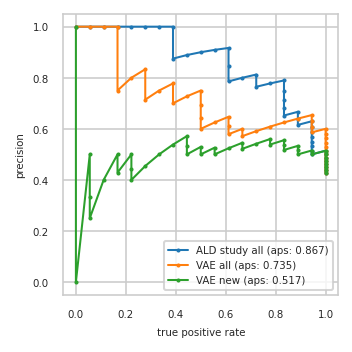

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.533 0.889
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.615 0.889     0.654 0.944     0.538 0.778
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.652 0.833     0.609 0.778     0.522 0.667
20         0.682 0.833     0.591 0.722     0.545 0.667
21         0.714 0.833     0.571 0.667     0.524 0.611
22         0.750 0.833     0.600 0.667     0.500 0.556
23         0.789 0.833     0.579 0.611     0.526 0.556
24         0.778 0.778     0.611 0.611     0.500 0.500
25         0.765 0.722     0.647 0.611     0.529 0.500
26         0.812 0.722     0.625 0.556     0.500 0.444
27         0.800 0.667     0.600 0.500     0.533 0.444
28         0.786 0.611     0.643 0.500     0.571 0.444
29         0.846 0.611     0.692 0.500     0.538 0.389
30         0.917 0.611     0.750 0.500     0.500 0.333
31         0.909 0.556     0.727 0.444     0.455 0.278
32         0.900 0.500     0.700 0.389     0.400 0.222
33         0.889 0.444     0.778 0.389     0.444 0.222
34         0.875 0.389     0.750 0.333     0.500 0.222
35         1.000 0.389     0.714 0.278     0.429 0.167
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.400 0.111
38         1.000 0.222     0.750 0.167     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


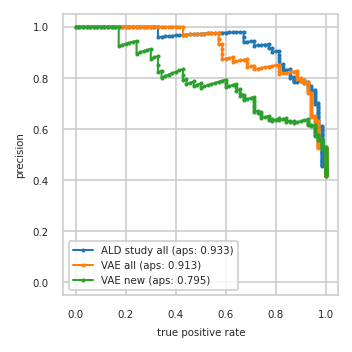

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


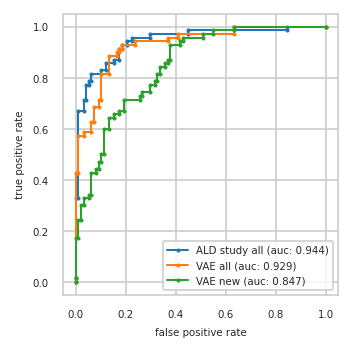

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}